In [1]:
import os # accessing directory structure
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt # plotting
%matplotlib inline

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from  IPython.display import display
import plotly.express as px

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, experimental, MaxPool2D, BatchNormalization
from tensorflow.keras.losses import sparse_categorical_crossentropy, binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau 
from tensorflow.data import Dataset
from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.random import set_seed
from tensorflow.keras.utils import to_categorical
from tensorflow import test
import random

# Set Seed
np.random.seed(11)
set_seed(11)
random.seed(11)

## Exploring the Data

* Age: range from 1 to 116
* Ethnicity: 0 - White, 1 - Black, 2 - Asian, 3 - Indian, 4 - Other
* Gender: 0 - male, 1 - female

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
age_gender_data = pd.read_csv("Z:\MIT FutureMakers\Week 3/age_gender.csv")
age_gender_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        23705 non-null  int64 
 1   ethnicity  23705 non-null  int64 
 2   gender     23705 non-null  int64 
 3   img_name   23705 non-null  object
 4   pixels     23705 non-null  object
dtypes: int64(3), object(2)
memory usage: 926.1+ KB


In [3]:
age_gender_data.head()

age  ethnicity  gender                        img_name  \
0    1          2       0  20161219203650636.jpg.chip.jpg   
1    1          2       0  20161219222752047.jpg.chip.jpg   
2    1          2       0  20161219222832191.jpg.chip.jpg   
3    1          2       0  20161220144911423.jpg.chip.jpg   
4    1          2       0  20161220144914327.jpg.chip.jpg   

                                              pixels  
0  129 128 128 126 127 130 133 135 139 142 145 14...  
1  164 74 111 168 169 171 175 182 184 188 193 199...  
2  67 70 71 70 69 67 70 79 90 103 116 132 145 155...  
3  193 197 198 200 199 200 202 203 204 205 208 21...  
4  202 205 209 210 209 209 210 211 212 214 218 21...

<AxesSubplot:xlabel='age', ylabel='count'>

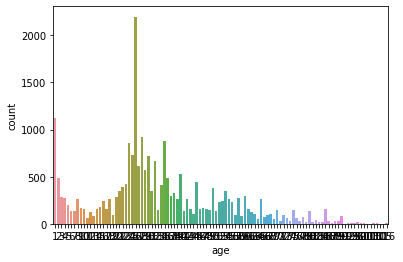

In [4]:
sns.countplot(x='age', data=age_gender_data) #age distribution

<AxesSubplot:xlabel='gender', ylabel='count'>

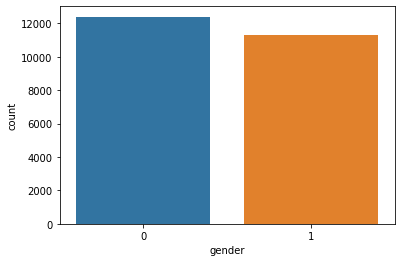

In [5]:
sns.countplot(x='gender', data=age_gender_data) #gender distribution

## Data Preprocessing

<AxesSubplot:xlabel='age', ylabel='count'>

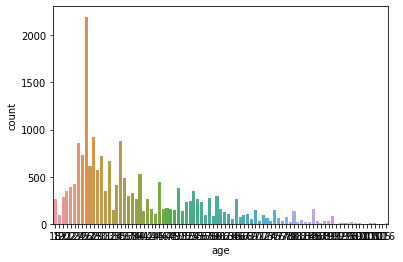

In [6]:
# Select only person who has age more than 18 
age_gender_data = age_gender_data[age_gender_data['age'] >= 18]
sns.countplot(x='age', data=age_gender_data) #age distribution

In [7]:
age_gender_data.reset_index(drop=True, inplace=True)
age_gender_data

age  ethnicity  gender                        img_name  \
0      100          0       0  20170112213500903.jpg.chip.jpg   
1      100          0       0  20170112215240346.jpg.chip.jpg   
2      100          0       1  20170110183726390.jpg.chip.jpg   
3      100          0       1  20170112213001988.jpg.chip.jpg   
4      100          0       1  20170112213303693.jpg.chip.jpg   
...    ...        ...     ...                             ...   
19467   99          0       1  20170120221920654.jpg.chip.jpg   
19468   99          1       1  20170120134639935.jpg.chip.jpg   
19469   99          2       1  20170110182418864.jpg.chip.jpg   
19470   99          2       1  20170117195405372.jpg.chip.jpg   
19471   99          0       1  20170110182052119.jpg.chip.jpg   

                                                  pixels  
0      203 185 139 163 176 184 186 175 175 156 159 13...  
1      125 126 115 78 66 66 77 85 95 102 117 138 138 ...  
2      235 164 113 144 121 201 243 237 234 221 233 23...  
3      82 82 82 82 82 82 84 86 90 85 104 105 102 154 ...  
4      70 72 94 149 154 166 175 169 172 161 176 187 2...  
...                                                  ...  
19467  127 100 94 81 77 77 74 99 102 98 128 145 160 1...  
19468  23 28 32 35 42 47 68 85 98 103 113 117 130 129...  
19469  59 50 37 40 34 19 30 101 156 170 177 184 187 1...  
19470  45 108 120 156 206 197 140 180 191 199 204 207...  
19471  156 161 160 165 170 173 166 177 183 191 187 18...  

[19472 rows x 5 columns]

In [8]:
age_gender_data.isnull().sum() # Check null data

age          0
ethnicity    0
gender       0
img_name     0
pixels       0
dtype: int64

In [9]:
# Input image configuration
num_pixels = len(age_gender_data['pixels'][0].split(' '))
dimension = int(np.sqrt(num_pixels))
img_width = dimension
img_height = dimension

print("Pixels: {}".format(num_pixels))
print("Width: {0}, Height: {1}".format(img_width, img_height))


Pixels: 2304
Width: 48, Height: 48


In [10]:
# Splitting dataset into X and y
X_img = age_gender_data.iloc[:,4].copy()
y_age = age_gender_data.iloc[:,0].copy()
y_ethnicity = age_gender_data.iloc[:,1].copy()
y_gender = age_gender_data.iloc[:,2].copy()

# splitting the data into train and test sets.
X_train, X_te, y_train, y_te = train_test_split(X_img,y_gender,test_size=0.3,random_state=11)
# splitting 'te' set into validation and test set
X_val, X_test, y_val, y_test = train_test_split(X_te,y_te,test_size=0.15,random_state=11)

def str_to_npArr(x):
    '''
    Function to convert pixel data (string) into numpy_array of pixels
    '''
    x = x.reset_index(drop=True)
    x = x.apply(lambda x: np.array(x.split(), dtype="float32")) #converting data to numpy array
    return np.array([x[i].reshape(img_width, img_height, 1) for i in range(x.shape[0])])

# Converting the string of pixels into image array for each of train, val and test set and normalization
X_train = str_to_npArr(X_train)
X_test = str_to_npArr(X_test)
X_val = str_to_npArr(X_val)

print("Target: shape = (16593, 48, 48, 1), type = <class 'numpy.ndarray'>")
print("Current: shape = {}, type = {}".format(X_train.shape, type(X_train)))

Target: shape = (16593, 48, 48, 1), type = <class 'numpy.ndarray'>
Current: shape = (13630, 48, 48, 1), type = <class 'numpy.ndarray'>


In [11]:
target_columns = ['gender', 'ethnicity', 'age']

age_gender_data_preprocess = age_gender_data.drop('img_name', axis=1)
y = age_gender_data_preprocess[target_columns]
X = age_gender_data_preprocess.drop(target_columns, axis=1)

print(X)
print("--------------------------------------------------------")
print(y)

                                                  pixels
0      203 185 139 163 176 184 186 175 175 156 159 13...
1      125 126 115 78 66 66 77 85 95 102 117 138 138 ...
2      235 164 113 144 121 201 243 237 234 221 233 23...
3      82 82 82 82 82 82 84 86 90 85 104 105 102 154 ...
4      70 72 94 149 154 166 175 169 172 161 176 187 2...
...                                                  ...
19467  127 100 94 81 77 77 74 99 102 98 128 145 160 1...
19468  23 28 32 35 42 47 68 85 98 103 113 117 130 129...
19469  59 50 37 40 34 19 30 101 156 170 177 184 187 1...
19470  45 108 120 156 206 197 140 180 191 199 204 207...
19471  156 161 160 165 170 173 166 177 183 191 187 18...

[19472 rows x 1 columns]
--------------------------------------------------------
       gender  ethnicity  age
0           0          0  100
1           0          0  100
2           1          0  100
3           1          0  100
4           1          0  100
...       ...        ...  ...
19467       1          

In [12]:
X = X['pixels'].apply(lambda x: np.array(x.split(), dtype="float32")) #converting data to numpy array
X = np.array(X)/255.0 # normalization
X = np.array([ X[i].reshape(48,48,1) for i in range(X.shape[0]) ])

print("Target: X Shape: {}".format(X.shape))
print("Current: X Shape: {}".format(X.shape))

Target: X Shape: (19472, 48, 48, 1)
Current: X Shape: (19472, 48, 48, 1)


In [13]:
y_gender = np.array(y['gender'])
y_ethnicity = np.array(y['ethnicity'])
y_age = np.array(y['age'])

## Data Visualization

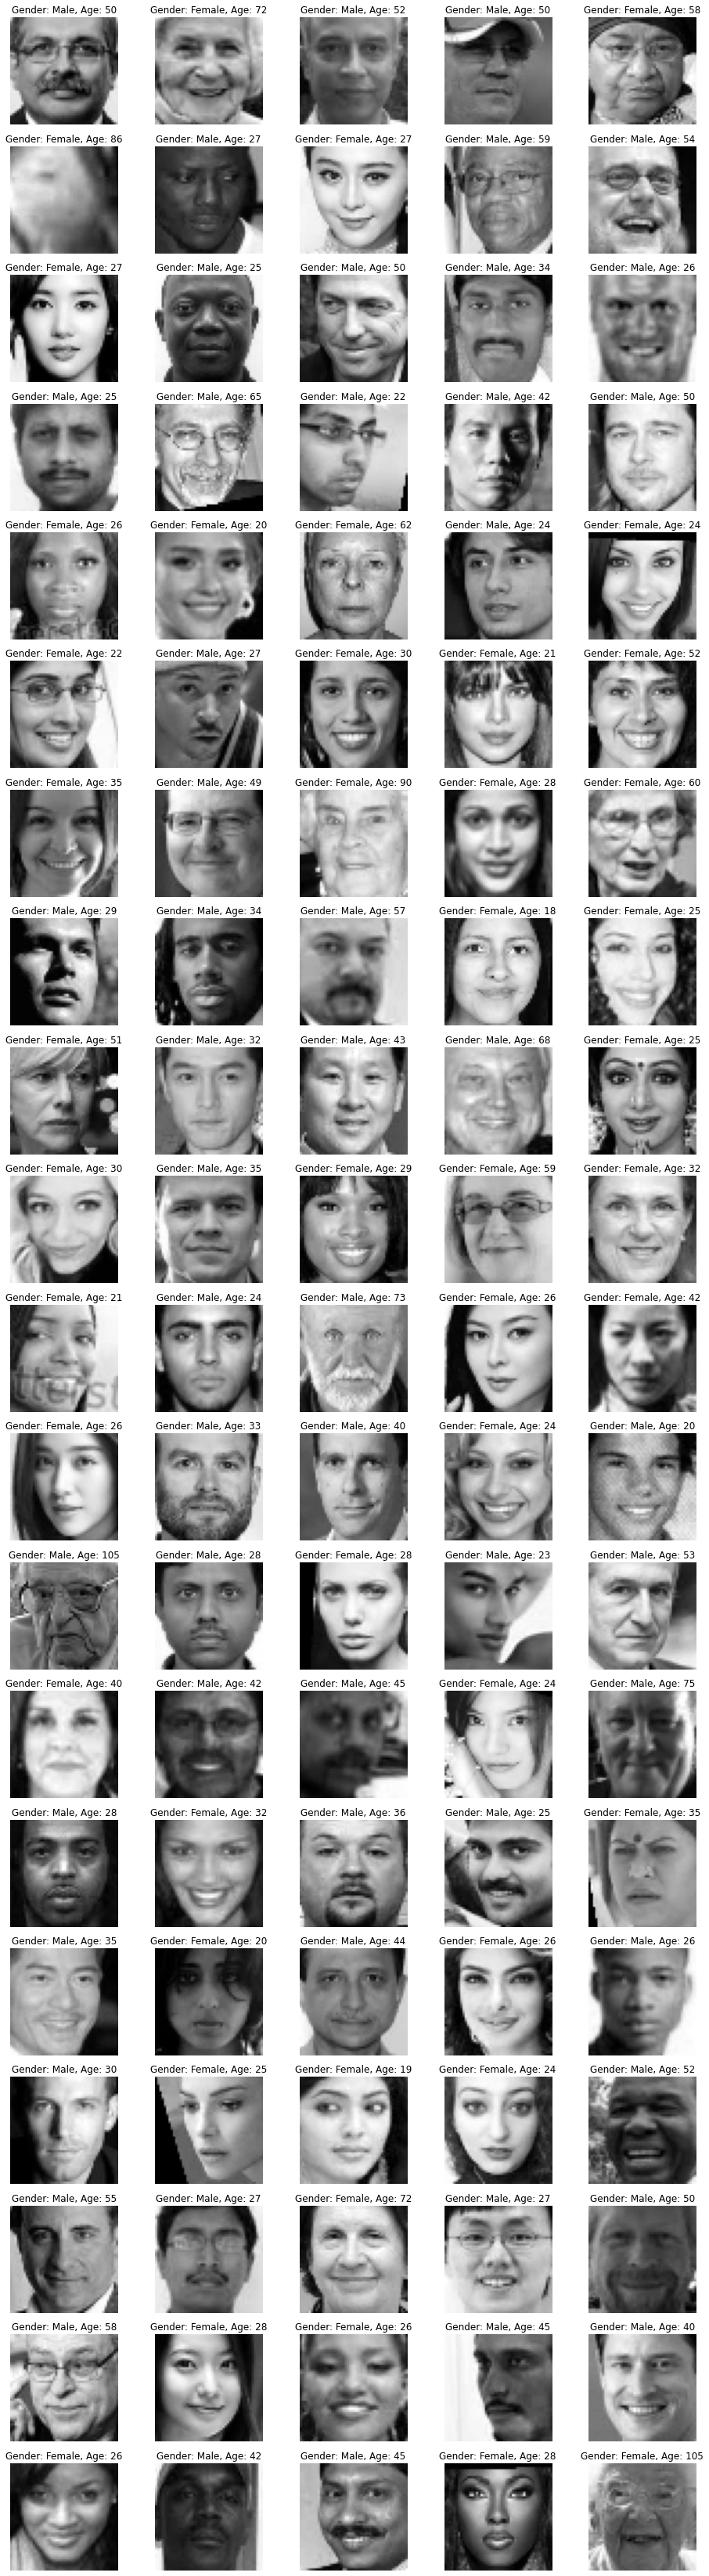

In [14]:
rows = 20 # rows in subplots
cols = 5 # columns in subplots
samp = random.sample(range(X.shape[0]),rows*cols) #selecting 100 random samples
x_samp = X[samp,:,:,:]
y_samp_gender = y_gender[samp]
y_samp_age = y_age[samp]
    
fig,ax = plt.subplots(rows,cols,figsize=(16,60))
r = 0
c = 0   

for i in range(rows*cols):
    aa = x_samp[i,:,:,:].reshape(48,48)
    ax[r,c].axis("off")
    ax[r,c].imshow(aa,cmap="gray")
    ax[r,c].set_title(f"Gender: {'Female' if y_samp_gender[i]==1 else 'Male'}, Age: {y_samp_age[i]}")
    c+=1
    if c == cols:
        c=0
        r+=1
        
plt.show()

## Image Augmentation

In [15]:
# Data augmentation is a technique used to increase the diversity of the training set 
# by applying random, but realistic transformations (ie. image rotation)
# We will do this for 100 samples

train_data_gen = ImageDataGenerator(rotation_range=30,
                                   width_shift_range=1,
                                    brightness_range=[0.8,1.2],
                                    zoom_range=[0.8,1.2],
                                    rescale=1/255
                                   )
val_data_gen = ImageDataGenerator(rescale=1/255)

test_data_gen = ImageDataGenerator(rescale=1/255)

In [16]:
set_seed(11)
random.seed(11)
np.random.seed(11)

val_data = val_data_gen.flow(X_val,y_val,
                                   seed=11,shuffle=False)

test_data = test_data_gen.flow(X_test,y_test,
                                   seed=11,shuffle=False)

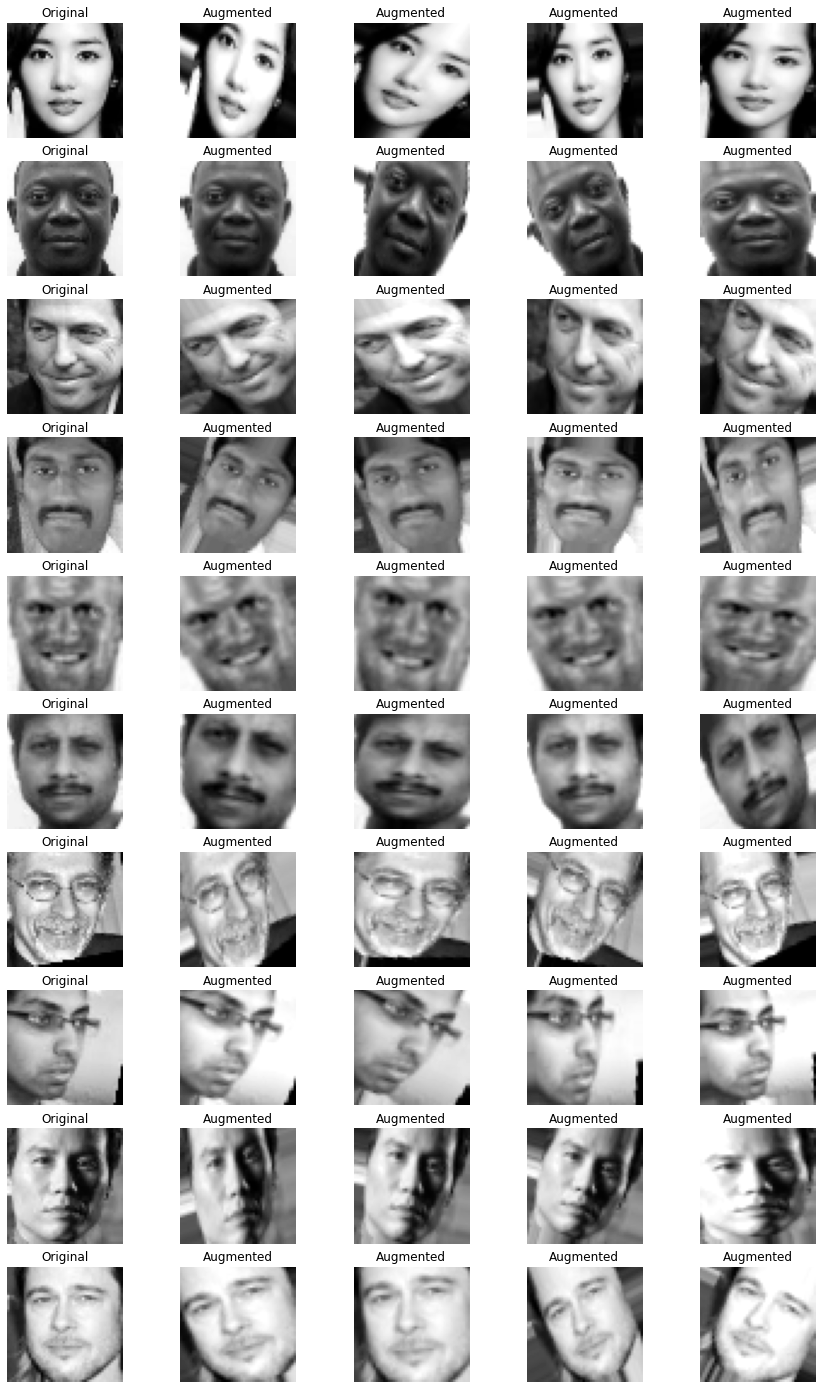

In [18]:
# Notice how the images are the same as the original, but slightly modified 

fig,ax = plt.subplots(10,5,figsize=(15,25))
for n in range(10):    
    r = random.sample(range(X.shape[0]),1)[0]
    ax[n,0].imshow(X[r].reshape(48,48),cmap="gray")
    ax[n,0].set_title("Original")
    ax[n,0].axis("off")
    for i in range(1,5):
        ax[n,i].imshow(train_data_gen.random_transform(X[r]).reshape(48,48),cmap="gray")
        ax[n,i].set_title("Augmented")
        ax[n,i].axis("off")
plt.show()

## Training

In [19]:
# Model configuration
batch_size = 32
img_width, img_height, img_num_channels = 48, 48, 1
loss_function = sparse_categorical_crossentropy
no_classes = 2
no_epochs = 50
optimizer = Adam()
verbosity = 1
num_folds = 10
activation='softmax'

# Determine shape of the data
input_shape = (img_width, img_height, img_num_channels)
input_shape

(48, 48, 1)

In [20]:
# Set Seed
random.seed(11)
set_seed(11)
np.random.seed(11)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

In [21]:
# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(X, y_gender):
    
  # Set Seed
  random.seed(11)
  set_seed(11)
  np.random.seed(11)
  
  # Define the model architecture
  model = Sequential()
  
  model.add(Conv2D(64, kernel_size=(3,3), input_shape=input_shape, activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(BatchNormalization())

  model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
  model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.3))
  model.add(BatchNormalization())

  model.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'))
  model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.3))
  model.add(BatchNormalization())

  model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.5))
  model.add(BatchNormalization())

  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(128, activation='softmax'))

  # Compile the model
  model.compile(loss=loss_function,
              optimizer=optimizer,
              metrics=['accuracy'])
  
  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
    
  early_stop = EarlyStopping(monitor="val_loss",patience=5,mode="min") # Ensure the model doesn't overfit
  
  # Set Seed
  random.seed(11)
  set_seed(11)
  np.random.seed(11)
    
  # Fit data to model
  history = model.fit(train_data_gen.flow(X[train], y_gender[train], seed=11),
            callbacks=early_stop,
            batch_size=batch_size,
            epochs=no_epochs,
            verbose=verbosity,
            validation_data=train_data_gen.flow(X[test], y_gender[test],
                                   seed=11))
  
  # Generate generalization metrics
  fig = px.line(
  history.history, y=['loss', 'val_loss'],
  labels={'index': 'epoch', 'value': 'loss'}, 
  title='Training History')
  fig.show()
    
  scores = model.evaluate(train_data_gen.flow(X[test], y_gender[test],
                                   seed=11), verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])
  
  # Increase fold number
  fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/50
548/548 [==============================] - 107s 195ms/step - loss: 0.5340 - accuracy: 0.7816 - val_loss: 0.6161 - val_accuracy: 0.6340
Epoch 2/50
548/548 [==============================] - 104s 190ms/step - loss: 0.3200 - accuracy: 0.8657 - val_loss: 0.2862 - val_accuracy: 0.8783
Epoch 3/50
548/548 [==============================] - 127s 232ms/step - loss: 0.2796 - accuracy: 0.8872 - val_loss: 0.4534 - val_accuracy: 0.7921
Epoch 4/50
548/548 [==============================] - 133s 242ms/step - loss: 0.2630 - accuracy: 0.8948 - val_loss: 0.2354 - val_accuracy: 0.9040
Epoch 5/50
548/548 [==============================] - 131s 240ms/step - loss: 0.2449 - accuracy: 0.9036 - val_loss: 0.2206 - val_accuracy: 0.9148
Epoch 6/50
548/548 [==============================] - 133s 242ms/step - loss: 0.2409 - accuracy: 0.9033 - val_loss: 0.3143 - val_accuracy: 0.8773
Epoch 7/50
548/548 [=======

Score for fold 1: loss of 0.1671237051486969; accuracy of 93.78849864006042%
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/50
548/548 [==============================] - 100s 181ms/step - loss: 0.5983 - accuracy: 0.7239 - val_loss: 0.5921 - val_accuracy: 0.6925
Epoch 2/50
548/548 [==============================] - 99s 181ms/step - loss: 0.3575 - accuracy: 0.8493 - val_loss: 0.3511 - val_accuracy: 0.8527
Epoch 3/50
548/548 [==============================] - 99s 181ms/step - loss: 0.3088 - accuracy: 0.8714 - val_loss: 0.3161 - val_accuracy: 0.8696
Epoch 4/50
548/548 [==============================] - 99s 181ms/step - loss: 0.2802 - accuracy: 0.8862 - val_loss: 0.2834 - val_accuracy: 0.8881
Epoch 5/50
548/548 [==============================] - 99s 181ms/step - loss: 0.2595 - accuracy: 0.8965 - val_loss: 0.3247 - val_accuracy: 0.8681
Epoch 6/50
548/548 [==============================] - 101s 185ms/step - loss: 0.2468 - accuracy: 0.9

Score for fold 2: loss of 0.2145490199327469; accuracy of 92.3511266708374%
------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/50
548/548 [==============================] - 106s 191ms/step - loss: 0.6016 - accuracy: 0.7246 - val_loss: 0.6355 - val_accuracy: 0.6097
Epoch 2/50
548/548 [==============================] - 104s 189ms/step - loss: 0.3744 - accuracy: 0.8377 - val_loss: 0.4201 - val_accuracy: 0.8197
Epoch 3/50
548/548 [==============================] - 104s 190ms/step - loss: 0.3123 - accuracy: 0.8720 - val_loss: 0.3758 - val_accuracy: 0.8285
Epoch 4/50
548/548 [==============================] - 105s 192ms/step - loss: 0.2862 - accuracy: 0.8859 - val_loss: 0.2870 - val_accuracy: 0.8803
Epoch 5/50
548/548 [==============================] - 105s 192ms/step - loss: 0.2642 - accuracy: 0.8944 - val_loss: 0.2641 - val_accuracy: 0.8963
Epoch 6/50
548/548 [==============================] - 105s 192ms/step - loss: 0.2501 - accuracy: 

Score for fold 3: loss of 0.17199648916721344; accuracy of 93.88803243637085%
------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/50
548/548 [==============================] - 105s 190ms/step - loss: 0.5471 - accuracy: 0.7625 - val_loss: 0.5741 - val_accuracy: 0.6662
Epoch 2/50
548/548 [==============================] - 105s 191ms/step - loss: 0.3577 - accuracy: 0.8491 - val_loss: 0.3634 - val_accuracy: 0.8516
Epoch 3/50
548/548 [==============================] - 105s 192ms/step - loss: 0.3100 - accuracy: 0.8725 - val_loss: 0.2986 - val_accuracy: 0.8726
Epoch 4/50
548/548 [==============================] - 213s 389ms/step - loss: 0.2909 - accuracy: 0.8814 - val_loss: 0.3096 - val_accuracy: 0.8711
Epoch 5/50
548/548 [==============================] - 106s 193ms/step - loss: 0.2625 - accuracy: 0.8941 - val_loss: 0.3002 - val_accuracy: 0.8665
Epoch 6/50
548/548 [==============================] - 106s 193ms/step - loss: 0.2485 - accuracy

Score for fold 4: loss of 0.20189835131168365; accuracy of 92.50128269195557%
------------------------------------------------------------------------
Training for fold 5 ...
Epoch 1/50
548/548 [==============================] - 104s 189ms/step - loss: 0.5485 - accuracy: 0.7595 - val_loss: 0.4476 - val_accuracy: 0.8151
Epoch 2/50
548/548 [==============================] - 107s 196ms/step - loss: 0.3394 - accuracy: 0.8555 - val_loss: 0.3203 - val_accuracy: 0.8685
Epoch 3/50
548/548 [==============================] - 105s 191ms/step - loss: 0.3051 - accuracy: 0.8759 - val_loss: 0.2726 - val_accuracy: 0.8880
Epoch 4/50
548/548 [==============================] - 108s 197ms/step - loss: 0.2746 - accuracy: 0.8880 - val_loss: 0.2517 - val_accuracy: 0.8993
Epoch 5/50
548/548 [==============================] - 108s 197ms/step - loss: 0.2599 - accuracy: 0.8976 - val_loss: 0.3180 - val_accuracy: 0.8680
Epoch 6/50
548/548 [==============================] - 110s 200ms/step - loss: 0.2440 - accuracy

Score for fold 5: loss of 0.20827984809875488; accuracy of 92.09039807319641%
------------------------------------------------------------------------
Training for fold 6 ...
Epoch 1/50
548/548 [==============================] - 110s 199ms/step - loss: 0.6102 - accuracy: 0.7166 - val_loss: 0.7848 - val_accuracy: 0.5871
Epoch 2/50
548/548 [==============================] - 110s 200ms/step - loss: 0.3728 - accuracy: 0.8398 - val_loss: 0.3193 - val_accuracy: 0.8629
Epoch 3/50
548/548 [==============================] - 107s 196ms/step - loss: 0.3187 - accuracy: 0.8688 - val_loss: 0.2766 - val_accuracy: 0.8834
Epoch 4/50
548/548 [==============================] - 108s 197ms/step - loss: 0.2911 - accuracy: 0.8831 - val_loss: 0.2982 - val_accuracy: 0.8695
Epoch 5/50
548/548 [==============================] - 106s 193ms/step - loss: 0.2697 - accuracy: 0.8922 - val_loss: 0.2555 - val_accuracy: 0.8911
Epoch 6/50
548/548 [==============================] - 110s 201ms/step - loss: 0.2525 - accuracy

Score for fold 6: loss of 0.19443684816360474; accuracy of 92.55264401435852%
------------------------------------------------------------------------
Training for fold 7 ...
Epoch 1/50
548/548 [==============================] - 109s 199ms/step - loss: 0.6002 - accuracy: 0.7247 - val_loss: 0.6407 - val_accuracy: 0.6697
Epoch 2/50
548/548 [==============================] - 108s 197ms/step - loss: 0.3627 - accuracy: 0.8448 - val_loss: 0.3060 - val_accuracy: 0.8711
Epoch 3/50
548/548 [==============================] - 110s 202ms/step - loss: 0.3131 - accuracy: 0.8718 - val_loss: 0.4437 - val_accuracy: 0.7930
Epoch 4/50
548/548 [==============================] - 105s 191ms/step - loss: 0.2867 - accuracy: 0.8821 - val_loss: 0.3191 - val_accuracy: 0.8582
Epoch 5/50
548/548 [==============================] - 112s 204ms/step - loss: 0.2654 - accuracy: 0.8948 - val_loss: 0.2313 - val_accuracy: 0.9086
Epoch 6/50
548/548 [==============================] - 114s 207ms/step - loss: 0.2512 - accuracy

Score for fold 7: loss of 0.17117320001125336; accuracy of 94.04211640357971%
------------------------------------------------------------------------
Training for fold 8 ...
Epoch 1/50
548/548 [==============================] - 120s 217ms/step - loss: 0.6211 - accuracy: 0.7116 - val_loss: 1.0412 - val_accuracy: 0.5347
Epoch 2/50
548/548 [==============================] - 115s 210ms/step - loss: 0.3931 - accuracy: 0.8312 - val_loss: 0.3983 - val_accuracy: 0.8130
Epoch 3/50
548/548 [==============================] - 116s 212ms/step - loss: 0.3242 - accuracy: 0.8657 - val_loss: 0.3211 - val_accuracy: 0.8701
Epoch 4/50
548/548 [==============================] - 116s 211ms/step - loss: 0.2974 - accuracy: 0.8782 - val_loss: 0.3063 - val_accuracy: 0.8757
Epoch 5/50
548/548 [==============================] - 117s 214ms/step - loss: 0.2758 - accuracy: 0.8911 - val_loss: 0.2825 - val_accuracy: 0.8875
Epoch 6/50
548/548 [==============================] - 116s 211ms/step - loss: 0.2581 - accuracy

Score for fold 8: loss of 0.17372184991836548; accuracy of 93.9393937587738%
------------------------------------------------------------------------
Training for fold 9 ...
Epoch 1/50
548/548 [==============================] - 102s 186ms/step - loss: 0.5838 - accuracy: 0.7365 - val_loss: 1.0981 - val_accuracy: 0.5460
Epoch 2/50
548/548 [==============================] - 101s 184ms/step - loss: 0.3668 - accuracy: 0.8469 - val_loss: 0.4817 - val_accuracy: 0.7673
Epoch 3/50
548/548 [==============================] - 103s 188ms/step - loss: 0.3175 - accuracy: 0.8713 - val_loss: 0.3420 - val_accuracy: 0.8649
Epoch 4/50
548/548 [==============================] - 102s 187ms/step - loss: 0.2871 - accuracy: 0.8846 - val_loss: 0.2742 - val_accuracy: 0.8891
Epoch 5/50
548/548 [==============================] - 102s 187ms/step - loss: 0.2584 - accuracy: 0.8965 - val_loss: 0.2797 - val_accuracy: 0.8880
Epoch 6/50
548/548 [==============================] - 102s 186ms/step - loss: 0.2481 - accuracy:

Score for fold 9: loss of 0.18108518421649933; accuracy of 93.01489591598511%
------------------------------------------------------------------------
Training for fold 10 ...
Epoch 1/50
548/548 [==============================] - 121s 219ms/step - loss: 0.6067 - accuracy: 0.7279 - val_loss: 0.4608 - val_accuracy: 0.7951
Epoch 2/50
548/548 [==============================] - 120s 219ms/step - loss: 0.3587 - accuracy: 0.8449 - val_loss: 0.2881 - val_accuracy: 0.8891
Epoch 3/50
548/548 [==============================] - 120s 218ms/step - loss: 0.3147 - accuracy: 0.8684 - val_loss: 0.2595 - val_accuracy: 0.9060
Epoch 4/50
548/548 [==============================] - 121s 222ms/step - loss: 0.2844 - accuracy: 0.8854 - val_loss: 0.3017 - val_accuracy: 0.8839
Epoch 5/50
548/548 [==============================] - 120s 219ms/step - loss: 0.2665 - accuracy: 0.8944 - val_loss: 0.3333 - val_accuracy: 0.8803
Epoch 6/50
548/548 [==============================] - 120s 219ms/step - loss: 0.2515 - accurac

Score for fold 10: loss of 0.171350359916687; accuracy of 93.99075508117676%


In [22]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.1671237051486969 - Accuracy: 93.78849864006042%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.2145490199327469 - Accuracy: 92.3511266708374%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.17199648916721344 - Accuracy: 93.88803243637085%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.20189835131168365 - Accuracy: 92.50128269195557%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.20827984809875488 - Accuracy: 92.09039807319641%
------------------------------------------------------------------------
> Fold 6 - Loss: 0.19443684816360474 - Accuracy: 92.55264401435852%
---------------------------------------------------------------------

In [23]:
# Set Seed
random.seed(11)
set_seed(11)
np.random.seed(11)
  
# Define the model architecture
model = Sequential()
  
model.add(Conv2D(64, kernel_size=(3,3), input_shape=input_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'))
model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='softmax'))

# Compile the model
model.compile(loss=loss_function,
              optimizer=optimizer,
              metrics=['accuracy'])

In [24]:
Final_train = np.append(X_train, X_val, axis=0)
Final_val = np.append(y_train, y_val, axis=0)
final_training_data = train_data_gen.flow(Final_train, Final_val,
                                   seed=11)

random.seed(11)
set_seed(11)
np.random.seed(11)
final_model_history = model.fit(train_data_gen.flow(X, y_gender, seed=11),batch_size=32,epochs=20, validation_data=val_data)

Epoch 1/20
609/609 [==============================] - 123s 200ms/step - loss: 0.6150 - accuracy: 0.7135 - val_loss: 0.6391 - val_accuracy: 0.6407
Epoch 2/20
609/609 [==============================] - 123s 201ms/step - loss: 0.3778 - accuracy: 0.8382 - val_loss: 0.4952 - val_accuracy: 0.7609
Epoch 3/20
609/609 [==============================] - 118s 194ms/step - loss: 0.3140 - accuracy: 0.8692 - val_loss: 0.2561 - val_accuracy: 0.8959
Epoch 4/20
609/609 [==============================] - 122s 200ms/step - loss: 0.2862 - accuracy: 0.8838 - val_loss: 0.2460 - val_accuracy: 0.9098
Epoch 5/20
609/609 [==============================] - 125s 206ms/step - loss: 0.2646 - accuracy: 0.8916 - val_loss: 0.2470 - val_accuracy: 0.9049
Epoch 6/20
609/609 [==============================] - 120s 196ms/step - loss: 0.2487 - accuracy: 0.9022 - val_loss: 0.2464 - val_accuracy: 0.9011
Epoch 7/20
609/609 [==============================] - 118s 193ms/step - loss: 0.2332 - accuracy: 0.9106 - val_loss: 0.2206 -

In [25]:
# Metrics
model.evaluate(test_data)

28/28 [==============================] - 1s 33ms/step - loss: 0.0953 - accuracy: 0.9704


[0.09534209221601486, 0.9703534841537476]

In [27]:
y_pred = np.argmax(model.predict(test_data), axis=-1)

In [28]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       468
           1       0.96      0.97      0.97       409

    accuracy                           0.97       877
   macro avg       0.97      0.97      0.97       877
weighted avg       0.97      0.97      0.97       877



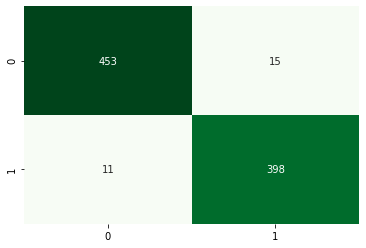

In [29]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='Greens', cbar=False, annot=True, fmt='d');

## Error Analysis

In [30]:
error_index = (y_test != y_pred) #finding error indices
y_test_error = y_test[error_index]
X_test_error = X_test[error_index]
prediction_error = y_pred[error_index]

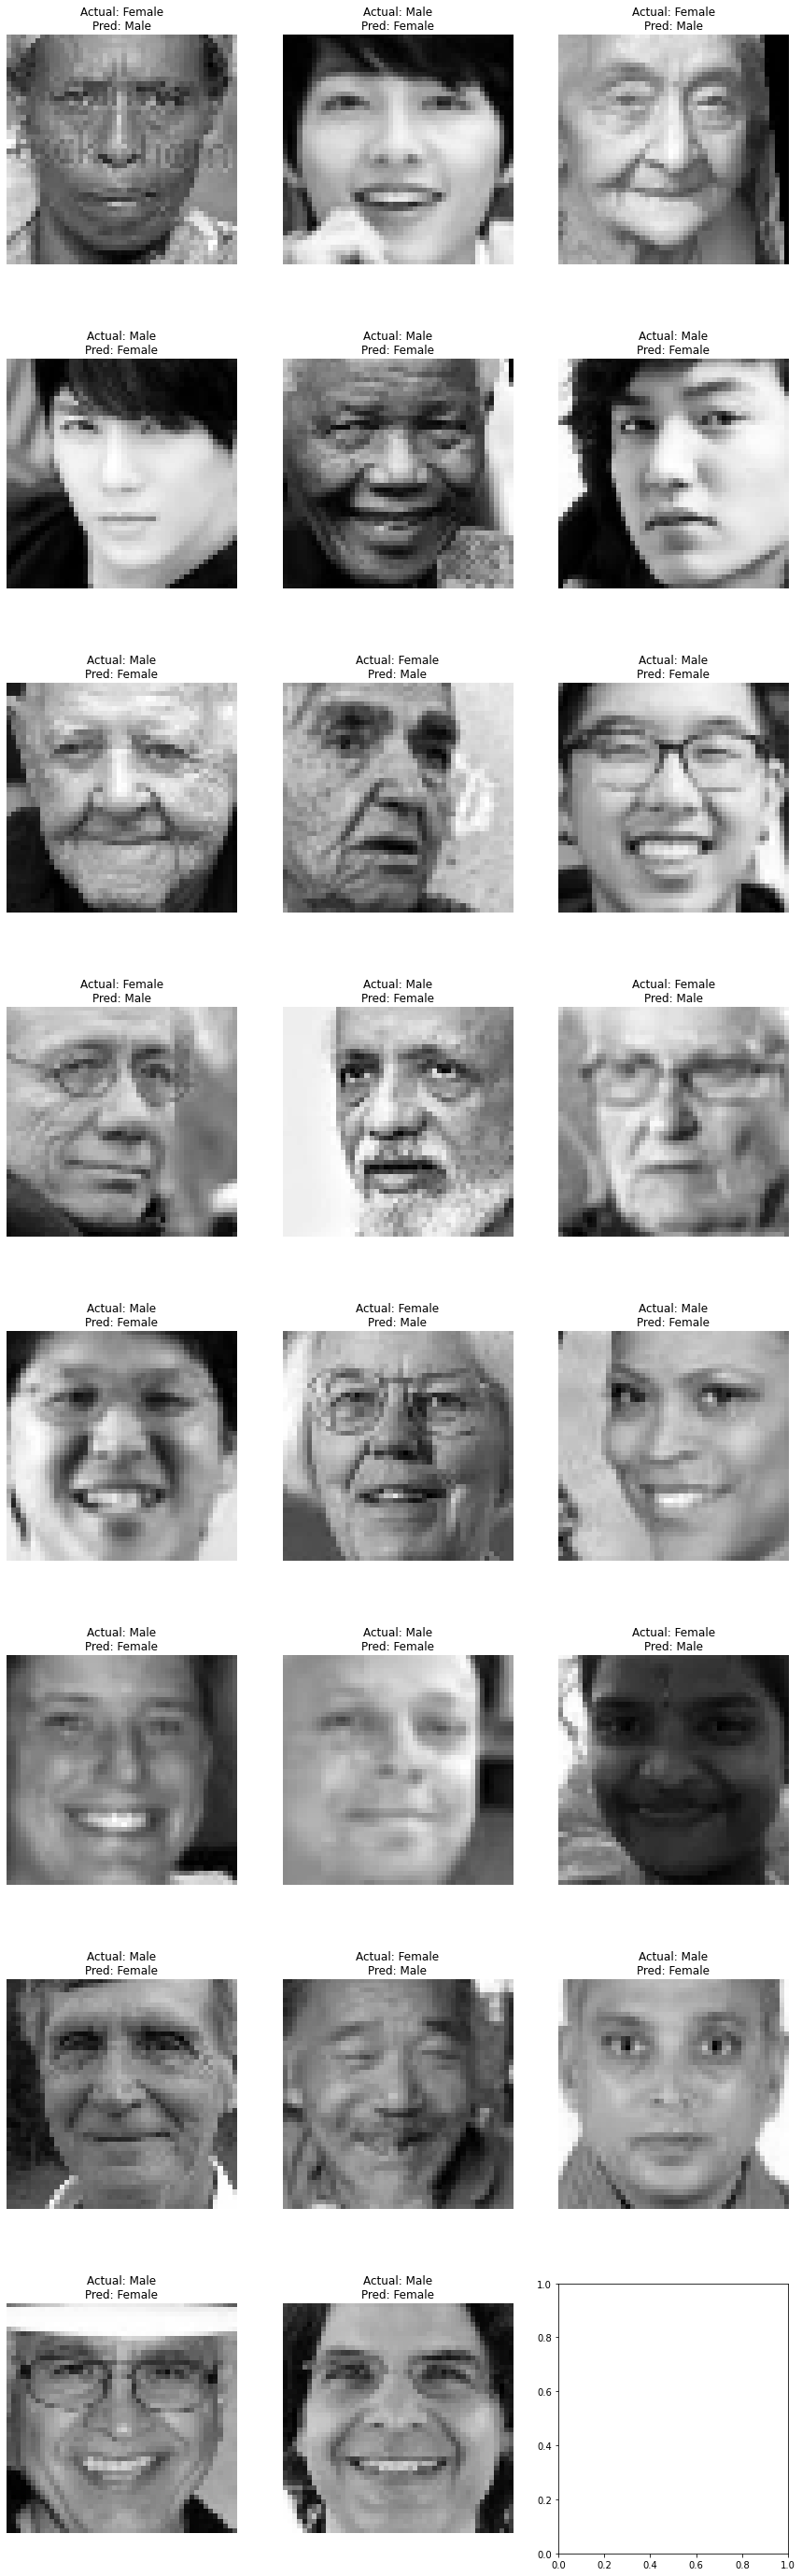

In [31]:
rows=int(np.floor(sum(error_index)/3)) #rows in subplots
cols=3 #columns in subplots
x_samp = X_test_error
y_samp = y_test_error

fig,ax = plt.subplots(rows,cols,figsize=(15,50))
r = 0
c = 0
for i in range((rows*cols)-1):
    aa = x_samp[i].reshape(48,48)
    ax[r,c].axis("off")
    ax[r,c].imshow(aa,cmap="gray")
    actual_lab = "Female" if y_samp.iloc[i]==1 else "Male"
    pred_lab = "Female" if int(prediction_error[i])==1 else "Male"
    ax[r,c].set_title(f'Actual: {actual_lab}\nPred: {pred_lab}')
    c+=1
    if c == cols:
        c=0
        r+=1
plt.show()